In [7]:
# !pip install ordered-set matplotlib torch transformers datasets shap scikit-learn

In [8]:
import re

In [9]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import transformers
import datasets
import shap

In [10]:
from string import punctuation

In [11]:
from IPython.display import clear_output

In [12]:
from ordered_set import OrderedSet
from collections import Counter

In [13]:
import random

In [14]:
import tensorflow as tf

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [15]:
from transformers import BertTokenizer, BertModel, AutoModel

In [16]:
import torch

In [17]:
import re

# Predictable Model

In [359]:
def change_y_to_onehot(y):
#     print(Counter(y)) #Counter({'1': 144, '-1': 82, '0': 22})
    class_set = OrderedSet(['1','-1','0']) #Positive, negative, neutral
    n_class = len(class_set) #3
    y_onehot_mapping = dict(zip(class_set, range(n_class))) #{'1': 0, '-1': 1, '0': 2}
#     print(y_onehot_mapping)
    onehot = []
    for label in y:
        tmp = [0] * n_class #temporary list of zero's [0, 0, 0]
        tmp[y_onehot_mapping[label]] = 1 #temporary list of sentiment labels e.g. [1, 0, 0] for positive
        onehot.append(tmp) #append the sentiment to onehot; results in a list of a list of sentiment labels e.g. [[1, 0, 0], [1, 0, 0], [1, 0, 0], ... ]
    return np.asarray(onehot, dtype=np.int32) 

In [360]:
def orderProb(probabilities):
    """
    convert probs from the classifier into the right format: [neg,neu,pos]
    """
    nr, nc = probabilities.shape
    correctProb = np.zeros((nr, nc))

    correctProb[:, 1] = probabilities[:, 2]
    correctProb[:, 2] = probabilities[:, 0]
    correctProb[:, 0] = probabilities[:, 1]

    return correctProb

In [361]:
def load_model(model_path):
    
    tf.reset_default_graph()
    # import the loaded graph
    imported_graph = tf.train.import_meta_graph(model_path + '.meta')
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    # restore the saved variables
    imported_graph.restore(sess, model_path)
    graph = tf.get_default_graph()
    
    return graph, sess

In [362]:
def update_embeddings(graph, sess, embeddings):
    required_dims = int(graph.get_tensor_by_name('word_embedding:0').shape[0])

    r, c = embeddings.shape
    new_w2v = np.concatenate([embeddings, np.zeros((required_dims-r, c))]).astype(np.float32)

    word_embedding = graph.get_tensor_by_name('word_embedding:0')
    assign_op = tf.assign(word_embedding, new_w2v)
    sess.run(assign_op)

In [363]:
def get_allProb(x_left, x_left_len, x_right, x_right_len, y_true, target_word, target_words_len, batch_size,
                num_samples, graph, sess):
    
    x = graph.get_tensor_by_name('inputs/Placeholder:0')
    y = graph.get_tensor_by_name('inputs/Placeholder_1:0')
    sen_len = graph.get_tensor_by_name('inputs/Placeholder_2:0')
    x_bw = graph.get_tensor_by_name('inputs/Placeholder_3:0')
    sen_len_bw = graph.get_tensor_by_name('inputs/Placeholder_4:0')
    target_words = graph.get_tensor_by_name('inputs/Placeholder_5:0')
    tar_len = graph.get_tensor_by_name('inputs/Placeholder_6:0')
    keep_prob1 = graph.get_tensor_by_name('Placeholder:0')
    keep_prob2 = graph.get_tensor_by_name('Placeholder_1:0')
    prob = graph.get_tensor_by_name('softmax/Softmax:0')
    
    probabilities = np.zeros((num_samples, 3))
    predictions = np.zeros(num_samples)

    feed_dict = {
        x: x_left, # x_left is also x_fw or x
        x_bw: x_right,
        y: y_true,
        sen_len: x_left_len, # sen_len is also sen_len_fw
        sen_len_bw: x_right_len,
        target_words: target_word,
        tar_len: target_words_len,
        keep_prob1: 1,
        keep_prob2: 1,
    }
    
    if x_left.shape[0] == 1:
        for k,v in feed_dict.items():
            if type(v) is np.ndarray:
                feed_dict[k] = np.concatenate([v, v], 0)
        

    ##getting prediction of instance

    prob = sess.run(prob, feed_dict=feed_dict) # prob matrix for all instances for the sentim (n_inst x 3)
    prob = orderProb(prob) # convert probs from the classifier into the right format: [neg,neu,pos]

    pred = np.argmax(prob, axis=1) - 1 # highest prob class chosen and coverted from 0, 1, 2 to corr sent

    probabilities = prob
    predictions = pred
    
#     print(x_left.shape)
    if x_left.shape[0] == 1:
        return probabilities[[0]]
    return probabilities

In [364]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-12_H-768_A-12')
bert_model = AutoModel.from_pretrained("google/bert_uncased_L-12_H-768_A-12", output_hidden_states=True)

Some weights of the model checkpoint at google/bert_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [365]:
def get_embeddings(text):
    
    global emb_i

    encoded_input = tokenizer(text, return_tensors='pt')
    output = bert_model(**encoded_input)

    embeddings = torch.concat(output[2][-5:-1], axis=0).sum(axis=0).detach().numpy()[1:-1]
    
    return embeddings

In [366]:
def find_full_text(text, dataset):
    match_ids = list()
    for t in text:
        pattern = re.escape(t.replace('...', 'DDD')).replace('DDD', '.*')
        for i, query in enumerate(dataset):
            match = re.findall('[^\n]*'+pattern+'[^\n]*', query.replace(' $T$', '').replace('$T$', '').strip())
            if len(match):
                match_ids.append(i)
    match_ids = np.array(match_ids)
    uniques, counts = np.unique(match_ids, return_counts=True)
    true_index = uniques[np.argmax(counts)]
    exact_match = dataset[true_index]
    return true_index, exact_match

In [367]:
def fill_t(full_text, masked_text):
    mask_splits = masked_text.split('...')
    if len(mask_splits) > 1:
        for k in range(len(mask_splits) - 1):
            ts_counts = sum(['$T$' in _ for _ in re.findall(mask_splits[k] + '.*' + mask_splits[k+1], full_text)])
            if ts_counts:
                break        

        mask_splits[k] = mask_splits[k] + ' $T$ '
        valid_text = ' '.join(mask_splits)
    else:
        valid_text = full_text # re.findall(f'[^\n]*{masked_text}[^\n]*', full_text)[0]
    
    return valid_text

In [368]:
def get_dl_input(inputs, sentence_len=80, target_len=19):

    all_embeddings = [[[0]*768]]
    x_left, x_right, target_word = [], [], []
    x_left_len, x_right_len, target_words_len = [], [], []
    st = 1

    for p in inputs:

        left, right = p[0].split('$T$')
        target = p[1]

        sentence = left + target + right

        embeddings = get_embeddings(sentence)

        embedding_ids = list()
        for t in [left, target, right]:
            tokens = tokenizer.tokenize(t)
            end = len(tokens)+st
            embedding_ids.append(list(range(st, end)))
            st = end

        x_left.append(embedding_ids[0] + [0] * (sentence_len - len(embedding_ids[0])))
        x_left_len.append(len(embedding_ids[0]))
        x_right.append(list(reversed(embedding_ids[2])) + [0] * (sentence_len - len(embedding_ids[2])))
        x_right_len.append(len(embedding_ids[2]))
        target_word.append(embedding_ids[1] + [0] * (target_len - len(embedding_ids[1])))
        target_words_len.append(len(embedding_ids[1]))
        all_embeddings.append(embeddings)
        
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    
    return np.array(x_left), np.array(x_left_len), np.array(x_right), np.array(x_right_len), \
        np.array(target_word), np.array(target_words_len), all_embeddings

In [369]:
def complete_graph_input(text, graph, sess):
    global data
    ind, full_text = find_full_text(text, data)
    new_text = [[fill_t(full_text, _), data[ind+1]] for _ in text]
    x_left, x_left_len, x_right, x_right_len, target_word, target_words_len, \
        all_embeddings = get_dl_input(new_text)
    size = len(text)
    y_true = [data[ind+2].strip().split()[0]]*size
    y_true = change_y_to_onehot(y_true)
    update_embeddings(graph, sess, all_embeddings)
    return x_left, x_left_len, x_right, x_right_len, y_true, target_word, target_words_len, int(size), int(size)

In [370]:
def prediction(text):
    graph, sess = load_model(model_path)
    inputs = complete_graph_input(text, graph, sess)
    probabilities = get_allProb(*inputs, graph, sess)
    del graph, sess
    return probabilities

In [371]:
# Make sure the created embeddings are correct
# sum(sum(get_embeddings('green tea creme brulee is a must!') == sess.run(graph.get_tensor_by_name('word_embedding:0'))[1:12])) == 768*11

# TESTING

In [127]:
print(prediction("the spotted that my table was shaking a stabilized it for me ."))

INFO:tensorflow:Restoring parameters from new_graph/-188
[[0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.17365915 0.35601893 0.47032195]
 [0.173

In [170]:
text = "spotted shaking stabilized ."
#text = "a"
data = data


def find_full_text(text, dataset):
    match_ids = list()
    for t in text:
        pattern = re.escape(t.replace('...', 'DDD')).replace('DDD', '.*')
        for i, query in enumerate(dataset):
            match = re.findall('[^\n]*'+pattern+'[^\n]*', query.replace(' $T$', '').replace('$T$', '').strip())
            if len(match):
                match_ids.append(i)
    match_ids = np.array(match_ids)
    uniques, counts = np.unique(match_ids, return_counts=True)
    true_index = uniques[np.argmax(counts)]
    exact_match = dataset[true_index]
    return true_index, exact_match


ind, full_text = find_full_text(text, data)
new_text = [[fill_t(full_text, _), data[ind+1]] for _ in text]

print(ind)
print(full_text)

12
the $T$ even spotted that my table was shaking a stabilized it for me .


In [226]:
text = "shaking stabilized ."
data = data

ind, full_text = find_full_text(text, data) #full_text


def fill_t(full_text, masked_text):
    mask_splits = masked_text.split('...')
    print(len(mask_splits))
    print(mask_splits[0])
    if len(mask_splits) > 1:
        for k in range(len(mask_splits) - 1):
            ts_counts = sum(['$T$' in _ for _ in re.findall(mask_splits[k] + '.*' + mask_splits[k+1], full_text)])
            if ts_counts:
                break        

        mask_splits[k] = mask_splits[k] + ' $T$ '
        print(mask_splits[k])
        valid_text = ' '.join(mask_splits)
    else:
        valid_text = full_text # re.findall(f'[^\n]*{masked_text}[^\n]*', full_text)[0]
    
    return valid_text

#new_text = [[fill_t(full_text, _), data[ind+1]] for _ in text]
new_text = [[fill_t(full_text, _), "TEST"] for _ in text]
print(new_text)


1
s
1
h
1
a
1
k
1
i
1
n
1
g
1
 
1
s
1
t
1
a
1
b
1
i
1
l
1
i
1
z
1
e
1
d
1
 
1
.
[['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for me .', 'TEST'], ['the $T$ even spotted that my table was shaking a stabilized it for 

In [231]:
text = ['the $T$ even spotted that my table was shaking a stabilized it for me .']
text = [_.replace(' $T$', '').replace('$T$', '').strip() for _ in text]
print(text)

def custom_tokenizer(s, return_offsets_mapping=True):

    """ Custom tokenizers conform to a subset of the transformers API.
    """
    pos = 0
    offset_ranges = []
    input_ids = []
    for m in re.finditer(r"\W", s):
        start, end = m.span(0)
        offset_ranges.append((pos, start))
        input_ids.append(s[pos:start])
        pos = end
    if pos != len(s):
        offset_ranges.append((pos, len(s)))
        input_ids.append(s[pos:])
    out = {}
    out["input_ids"] = input_ids
    if return_offsets_mapping:
        out["offset_mapping"] = offset_ranges
    return out

masker = shap.maskers.Text(custom_tokenizer)
print(masker(text))
explainer = shap.Explainer(prediction, masker, output_names=labels)

['the even spotted that my table was shaking a stabilized it for me .']


TypeError: __call__() missing 1 required positional argument: 's'

In [223]:
a = ['test']
print(a[0][0])

t


# SHAP Integration

In [372]:
model_path = 'new_graph/-188'

In [373]:
with open('text_only.txt', 'r') as file:
    data = file.readlines()
data = [_.strip() for _ in data]

In [374]:
shap_inputs = data[::3]
shap_inputs = [_.replace(' $T$', '').replace('$T$', '').strip() for _ in shap_inputs]

In [375]:
labels = ['negative', 'neutral', 'positive']

In [376]:
def custom_tokenizer(s, return_offsets_mapping=True):

    """ Custom tokenizers conform to a subset of the transformers API.
    """
    pos = 0
    offset_ranges = []
    input_ids = []
    for m in re.finditer(r"\W", s):
        start, end = m.span(0)
        offset_ranges.append((pos, start))
        input_ids.append(s[pos:start])
        pos = end
    if pos != len(s):
        offset_ranges.append((pos, len(s)))
        input_ids.append(s[pos:])
    out = {}
    out["input_ids"] = input_ids
    if return_offsets_mapping:
        out["offset_mapping"] = offset_ranges
    return out

masker = shap.maskers.Text(custom_tokenizer)
explainer = shap.Explainer(prediction, masker, output_names=labels)

In [377]:
inputs = shap_inputs
print(inputs)

['the is mixed yuppies , young and old .', 'for the amount of we got the prices should have been lower .', 'to their credit they removed the dish from the check ; but no stopped by to ask what the problem was .', '- this is unbelievably over-rated .', 'though , one thing i realized later on was that the restaurant either used msg or a meat tenderizer on the .', 'the even spotted that my table was shaking a stabilized it for me .', 'be sure to try the .', 'this rocks ! !', "our continued to be attentive throughout the night , but i did remain puzzled by one issue : who thinks that ray 's is an appropriate place to take young children for dinner ?", 'i liked the very much but the food was not worth the price .', 'plenty of , trust me .', 'they have a wide variety of and they even list which oceans they come from ; atlantic or pacific .']


In [378]:
shap_values = explainer(inputs)

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188


  0%|                                                                                                                                                                                                                                                                                           | 0/90 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188


 11%|██████████████████████████████▍                                                                                                                                                                                                                                                   | 10/90 [00:21<02:52,  2.16s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 18%|████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 16/90 [00:40<03:12,  2.61s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 24%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 22/90 [00:58<03:09,  2.78s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 31%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 28/90 [01:16<02:57,  2.86s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 34/90 [01:34<02:42,  2.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 40/90 [01:52<02:25,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 46/90 [02:09<02:07,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 52/90 [02:29<01:56,  3.05s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 58/90 [02:47<01:36,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 64/90 [03:04<01:16,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 70/90 [03:21<00:59,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 76/90 [03:38<00:40,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 82/90 [03:58<00:24,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188


Partition explainer:   8%|█████████████████████▊                                                                                                                                                                                                                                                | 1/12 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/156 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  6%|█████████████████▌                                                                                                                                                                                                                                                               | 10/156 [00:18<04:22,  1.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 10%|████████████████████████████                                                                                                                                                                                                                                                     | 16/156 [00:36<05:30,  2.36s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                          | 22/156 [00:53<05:48,  2.60s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 18%|█████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/156 [01:09<05:34,  2.61s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                     | 34/156 [01:25<05:19,  2.62s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 26%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                           | 40/156 [01:42<05:12,  2.69s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 46/156 [01:59<05:03,  2.76s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 33%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 52/156 [02:17<04:52,  2.82s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 58/156 [02:35<04:42,  2.88s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 64/156 [02:52<04:23,  2.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 70/156 [03:10<04:08,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 76/156 [03:28<03:55,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 82/156 [03:46<03:38,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 88/156 [04:04<03:22,  2.98s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 94/156 [04:24<03:10,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 100/156 [04:43<02:52,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 106/156 [05:02<02:35,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 112/156 [05:21<02:18,  3.14s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 118/156 [05:40<01:59,  3.15s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                             | 3/12 [12:27<31:26, 209.61s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/498 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  2%|█████▍                                                                                                                                                                                                                                                                           | 10/498 [00:17<14:21,  1.76s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  3%|████████▊                                                                                                                                                                                                                                                                        | 16/498 [00:34<18:18,  2.28s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  4%|████████████                                                                                                                                                                                                                                                                     | 22/498 [00:52<20:18,  2.56s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  6%|███████████████▎                                                                                                                                                                                                                                                                 | 28/498 [01:11<21:35,  2.76s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  7%|██████████████████▋                                                                                                                                                                                                                                                              | 34/498 [01:29<22:06,  2.86s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  8%|█████████████████████▉                                                                                                                                                                                                                                                           | 40/498 [01:49<22:41,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  9%|█████████████████████████▏                                                                                                                                                                                                                                                       | 46/498 [02:09<23:19,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 10%|████████████████████████████▌                                                                                                                                                                                                                                                    | 52/498 [02:30<24:14,  3.26s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 12%|███████████████████████████████▊                                                                                                                                                                                                                                                 | 58/498 [02:53<24:58,  3.41s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 13%|███████████████████████████████████                                                                                                                                                                                                                                              | 64/498 [03:13<24:26,  3.38s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                          | 70/498 [03:34<24:24,  3.42s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 15%|█████████████████████████████████████████▋                                                                                                                                                                                                                                       | 76/498 [03:55<24:17,  3.45s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                    | 82/498 [04:14<23:29,  3.39s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 18%|████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 88/498 [04:32<22:10,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 19%|███████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 94/498 [04:52<22:07,  3.28s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 100/498 [05:11<21:26,  3.23s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                      | 106/498 [05:31<21:22,  3.27s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 112/498 [05:50<20:52,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 24%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 118/498 [06:09<20:13,  3.19s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 25%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                            | 124/498 [06:27<19:37,  3.15s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 26%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 130/498 [06:47<19:34,  3.19s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 27%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 136/498 [07:04<18:36,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 142/498 [07:22<18:08,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 30%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 148/498 [07:40<17:55,  3.07s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 31%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 154/498 [07:59<17:42,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 32%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 160/498 [08:18<17:36,  3.13s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 166/498 [08:36<17:04,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 35%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 172/498 [08:54<16:41,  3.07s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 178/498 [09:12<16:08,  3.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 184/498 [09:30<15:43,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 190/498 [09:47<15:20,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 196/498 [10:06<15:07,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 202/498 [10:23<14:46,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 208/498 [10:42<14:36,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 214/498 [11:01<14:25,  3.05s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 220/498 [11:19<14:06,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 226/498 [11:37<13:39,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 232/498 [11:54<13:18,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 238/498 [12:13<13:06,  3.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 244/498 [13:27<24:32,  5.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 250/498 [13:56<22:47,  5.52s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 256/498 [14:15<19:23,  4.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 262/498 [14:33<16:48,  4.27s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 268/498 [14:50<14:45,  3.85s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 274/498 [15:07<13:14,  3.54s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 280/498 [15:25<12:13,  3.37s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 286/498 [15:41<11:17,  3.20s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 292/498 [15:58<10:35,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 298/498 [16:15<10:02,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 304/498 [16:32<09:33,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 310/498 [16:49<09:05,  2.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 316/498 [17:06<08:43,  2.88s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 322/498 [17:21<08:08,  2.78s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 328/498 [17:38<07:55,  2.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 334/498 [17:56<07:46,  2.84s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 340/498 [18:12<07:22,  2.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 346/498 [18:29<07:02,  2.78s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 352/498 [18:46<06:49,  2.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 358/498 [19:03<06:35,  2.83s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 364/498 [19:20<06:21,  2.85s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 370/498 [19:39<06:12,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 376/498 [19:56<05:56,  2.93s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 382/498 [20:13<05:35,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 388/498 [20:32<05:23,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 394/498 [20:50<05:07,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 400/498 [21:08<04:54,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 406/498 [21:28<04:42,  3.07s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  33%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 4/12 [35:10<1:32:03, 690.40s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                           | 0/56 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



 18%|████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 10/56 [00:16<01:15,  1.63s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 16/56 [00:34<01:29,  2.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 22/56 [00:50<01:22,  2.43s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 28/56 [01:07<01:13,  2.61s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 34/56 [01:25<01:00,  2.74s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 40/56 [01:42<00:43,  2.74s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5/12 [38:04<58:04, 497.85s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/498 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  2%|█████▍                                                                                                                                                                                                                                                                           | 10/498 [00:19<16:13,  1.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  3%|████████▊                                                                                                                                                                                                                                                                        | 16/498 [00:39<20:43,  2.58s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  4%|████████████                                                                                                                                                                                                                                                                     | 22/498 [00:59<22:48,  2.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  6%|███████████████▎                                                                                                                                                                                                                                                                 | 28/498 [01:18<23:25,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  7%|██████████████████▋                                                                                                                                                                                                                                                              | 34/498 [01:37<23:40,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  8%|█████████████████████▉                                                                                                                                                                                                                                                           | 40/498 [01:56<23:21,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  9%|█████████████████████████▏                                                                                                                                                                                                                                                       | 46/498 [02:18<24:32,  3.26s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 10%|████████████████████████████▌                                                                                                                                                                                                                                                    | 52/498 [02:39<24:49,  3.34s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 12%|███████████████████████████████▊                                                                                                                                                                                                                                                 | 58/498 [02:58<23:59,  3.27s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 13%|███████████████████████████████████                                                                                                                                                                                                                                              | 64/498 [03:15<22:53,  3.16s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                          | 70/498 [03:34<22:21,  3.13s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 15%|█████████████████████████████████████████▋                                                                                                                                                                                                                                       | 76/498 [03:53<22:23,  3.18s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                    | 82/498 [04:15<22:51,  3.30s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 18%|████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 88/498 [04:33<22:00,  3.22s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 19%|███████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 94/498 [04:50<20:57,  3.11s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 100/498 [05:09<20:51,  3.15s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                      | 106/498 [05:27<20:15,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 112/498 [05:46<20:00,  3.11s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 24%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 118/498 [06:05<19:38,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 25%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                            | 124/498 [06:24<19:28,  3.12s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 26%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 130/498 [06:43<19:18,  3.15s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 27%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 136/498 [07:00<18:28,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 142/498 [07:17<17:41,  2.98s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 30%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 148/498 [07:35<17:25,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 31%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 154/498 [07:53<17:12,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 32%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 160/498 [08:11<16:51,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 166/498 [08:29<16:41,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 35%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 172/498 [08:49<16:51,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 178/498 [09:07<16:18,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 184/498 [09:25<16:01,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 190/498 [09:41<15:05,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 196/498 [09:56<14:08,  2.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 202/498 [10:15<14:12,  2.88s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 208/498 [10:30<13:26,  2.78s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 214/498 [10:46<13:05,  2.77s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 220/498 [11:04<13:01,  2.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 226/498 [11:22<13:06,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 232/498 [11:42<13:20,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 238/498 [12:00<12:58,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 244/498 [12:16<12:16,  2.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 250/498 [12:30<11:19,  2.74s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 256/498 [12:46<10:56,  2.71s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 262/498 [13:03<10:55,  2.78s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 268/498 [13:21<10:47,  2.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 274/498 [13:35<09:59,  2.68s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 280/498 [13:51<09:42,  2.67s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 286/498 [14:10<10:01,  2.84s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 292/498 [14:28<09:51,  2.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 298/498 [14:43<09:15,  2.78s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 304/498 [15:00<09:00,  2.79s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 310/498 [15:17<08:47,  2.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 316/498 [15:35<08:42,  2.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 322/498 [15:53<08:29,  2.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 328/498 [16:11<08:13,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 334/498 [16:27<07:45,  2.84s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 340/498 [16:45<07:35,  2.88s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 346/498 [17:03<07:24,  2.93s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 352/498 [17:19<06:57,  2.86s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 358/498 [17:37<06:44,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 364/498 [17:55<06:35,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 370/498 [18:15<06:31,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 376/498 [18:34<06:14,  3.07s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 382/498 [18:52<05:54,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 388/498 [19:13<05:49,  3.18s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 394/498 [19:31<05:24,  3.12s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 400/498 [19:49<05:03,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 406/498 [20:07<04:43,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 412/498 [20:26<04:24,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 418/498 [20:45<04:08,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 424/498 [21:00<03:38,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 430/498 [21:18<03:22,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 436/498 [21:36<03:03,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 442/498 [21:54<02:47,  2.98s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 448/498 [22:14<02:34,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 454/498 [22:28<02:06,  2.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 460/498 [22:43<01:43,  2.72s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 466/498 [22:57<01:23,  2.62s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 472/498 [23:13<01:08,  2.65s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 478/498 [23:32<00:55,  2.79s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 484/498 [23:51<00:40,  2.92s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 490/498 [24:10<00:23,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/498 [24:29<00:06,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



500it [24:48,  3.41s/it]                                                                                                                                                                                                                                                                                               
Partition explainer:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 6/12 [1:03:45<1:26:02, 860.47s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/182 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  5%|███████████████                                                                                                                                                                                                                                                                  | 10/182 [00:17<04:54,  1.71s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  9%|████████████████████████                                                                                                                                                                                                                                                         | 16/182 [00:35<06:27,  2.33s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 12%|█████████████████████████████████                                                                                                                                                                                                                                                | 22/182 [00:53<06:59,  2.62s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 15%|██████████████████████████████████████████                                                                                                                                                                                                                                       | 28/182 [01:12<07:06,  2.77s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 19%|███████████████████████████████████████████████████                                                                                                                                                                                                                              | 34/182 [01:33<07:26,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 40/182 [01:50<07:04,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 25%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                            | 46/182 [02:09<06:50,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 52/182 [02:26<06:27,  2.98s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 32%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 58/182 [03:03<07:51,  3.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 35%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 64/182 [03:29<08:08,  4.14s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 70/182 [04:08<09:01,  4.83s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 76/182 [04:26<07:34,  4.29s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 82/182 [04:44<06:28,  3.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 88/182 [05:01<05:36,  3.58s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 94/182 [05:18<04:54,  3.35s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 100/182 [05:35<04:23,  3.22s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 106/182 [05:52<03:55,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 112/182 [06:09<03:31,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 118/182 [06:25<03:06,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 124/182 [06:39<02:39,  2.75s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 130/182 [06:53<02:14,  2.59s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 136/182 [07:08<01:58,  2.57s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7/12 [1:12:02<1:01:39, 739.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                           | 0/30 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



 33%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 10/30 [00:13<00:26,  1.34s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 16/30 [00:27<00:25,  1.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 22/30 [00:40<00:15,  1.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 8/12 [1:13:44<35:38, 534.73s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                           | 0/20 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 10/20 [00:15<00:15,  1.54s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16/20 [00:31<00:08,  2.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 9/12 [1:15:12<19:42, 394.15s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/498 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  2%|█████▍                                                                                                                                                                                                                                                                           | 10/498 [00:18<15:13,  1.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  3%|████████▊                                                                                                                                                                                                                                                                        | 16/498 [00:38<20:05,  2.50s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  4%|████████████                                                                                                                                                                                                                                                                     | 22/498 [00:56<21:45,  2.74s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  6%|███████████████▎                                                                                                                                                                                                                                                                 | 28/498 [01:15<22:32,  2.88s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  7%|██████████████████▋                                                                                                                                                                                                                                                              | 34/498 [01:34<23:09,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  8%|█████████████████████▉                                                                                                                                                                                                                                                           | 40/498 [01:53<23:20,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  9%|█████████████████████████▏                                                                                                                                                                                                                                                       | 46/498 [02:13<23:27,  3.11s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 10%|████████████████████████████▌                                                                                                                                                                                                                                                    | 52/498 [02:32<23:12,  3.12s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 12%|███████████████████████████████▊                                                                                                                                                                                                                                                 | 58/498 [02:50<22:39,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 13%|███████████████████████████████████                                                                                                                                                                                                                                              | 64/498 [03:09<22:28,  3.11s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                          | 70/498 [03:26<21:40,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 15%|█████████████████████████████████████████▋                                                                                                                                                                                                                                       | 76/498 [03:43<21:07,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                    | 82/498 [04:02<20:58,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 18%|████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 88/498 [04:19<20:11,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 19%|███████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 94/498 [04:37<19:57,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 100/498 [04:55<19:52,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                      | 106/498 [05:13<19:43,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 112/498 [05:31<19:15,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 24%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 118/498 [05:49<18:51,  2.98s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 25%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                            | 124/498 [06:06<18:26,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 26%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 130/498 [06:25<18:28,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 27%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 136/498 [06:41<17:37,  2.92s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 142/498 [06:59<17:26,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 30%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 148/498 [07:18<17:23,  2.98s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 31%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 154/498 [07:38<17:49,  3.11s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 32%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 160/498 [07:55<17:06,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 166/498 [08:16<17:23,  3.14s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 35%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 172/498 [08:31<16:15,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 178/498 [08:46<15:08,  2.84s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 184/498 [09:04<14:54,  2.85s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 190/498 [09:23<15:13,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 196/498 [09:40<14:38,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 202/498 [09:58<14:31,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 208/498 [10:15<14:12,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 214/498 [10:31<13:26,  2.84s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 220/498 [10:48<13:12,  2.85s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 226/498 [11:09<13:41,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 232/498 [11:27<13:19,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 238/498 [11:44<12:52,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 244/498 [12:04<12:55,  3.05s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 250/498 [12:23<12:46,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 256/498 [12:40<12:10,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 262/498 [12:58<11:56,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 268/498 [13:16<11:36,  3.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 274/498 [13:34<11:13,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 280/498 [13:54<11:22,  3.13s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 286/498 [14:14<11:11,  3.17s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 292/498 [14:35<11:08,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 298/498 [14:57<11:17,  3.39s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 304/498 [15:16<10:48,  3.34s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 310/498 [15:37<10:31,  3.36s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 316/498 [15:56<10:06,  3.33s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 322/498 [16:17<09:55,  3.39s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 328/498 [16:38<09:35,  3.39s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 334/498 [16:59<09:22,  3.43s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 340/498 [17:17<08:39,  3.29s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 346/498 [17:36<08:15,  3.26s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 352/498 [17:56<08:01,  3.30s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 358/498 [18:14<07:30,  3.22s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 364/498 [18:32<07:02,  3.16s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 370/498 [18:52<06:49,  3.20s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 376/498 [19:09<06:18,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 382/498 [19:28<06:02,  3.12s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 388/498 [19:46<05:37,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 394/498 [20:05<05:21,  3.09s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 400/498 [20:23<05:01,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 406/498 [20:40<04:35,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 412/498 [20:58<04:15,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 418/498 [21:15<03:56,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 424/498 [21:33<03:39,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 430/498 [21:51<03:21,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 436/498 [22:08<03:02,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 442/498 [22:27<02:47,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 448/498 [22:43<02:25,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 454/498 [23:03<02:12,  3.02s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 460/498 [23:22<01:57,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 466/498 [23:40<01:37,  3.05s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 472/498 [23:59<01:19,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 478/498 [24:17<01:01,  3.05s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 484/498 [24:37<00:44,  3.16s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 490/498 [24:59<00:26,  3.29s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/498 [25:18<00:06,  3.28s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



500it [25:37,  3.60s/it]                                                                                                                                                                                                                                                                                               
Partition explainer:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 10/12 [1:41:44<25:31, 765.66s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/182 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  5%|███████████████                                                                                                                                                                                                                                                                  | 10/182 [00:15<04:32,  1.58s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  9%|████████████████████████                                                                                                                                                                                                                                                         | 16/182 [00:33<06:09,  2.23s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 12%|█████████████████████████████████                                                                                                                                                                                                                                                | 22/182 [00:50<06:35,  2.47s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 15%|██████████████████████████████████████████                                                                                                                                                                                                                                       | 28/182 [01:07<06:33,  2.56s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 19%|███████████████████████████████████████████████████                                                                                                                                                                                                                              | 34/182 [01:26<06:54,  2.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 40/182 [01:45<06:53,  2.91s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 25%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                            | 46/182 [02:03<06:42,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 29%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 52/182 [02:23<06:40,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 32%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 58/182 [02:41<06:15,  3.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 35%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 64/182 [03:00<06:01,  3.07s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 70/182 [03:19<05:47,  3.11s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 76/182 [03:40<05:41,  3.22s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 82/182 [03:59<05:19,  3.20s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 88/182 [04:19<05:07,  3.27s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 94/182 [04:39<04:47,  3.27s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 100/182 [04:58<04:26,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 106/182 [05:17<04:04,  3.22s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 112/182 [05:37<03:48,  3.27s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 118/182 [05:57<03:28,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 124/182 [06:16<03:07,  3.23s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 130/182 [06:33<02:42,  3.12s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 136/182 [06:49<02:18,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 142/182 [07:05<01:55,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 148/182 [07:23<01:39,  2.92s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 154/182 [07:38<01:18,  2.81s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 160/182 [07:56<01:02,  2.86s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 166/182 [08:14<00:46,  2.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 11/12 [1:51:16<11:46, 706.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                           | 0/42 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



 24%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                | 10/42 [00:18<00:58,  1.82s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 16/42 [00:36<01:02,  2.39s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 22/42 [00:54<00:52,  2.63s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 28/42 [01:11<00:37,  2.68s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 34/42 [01:29<00:22,  2.82s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



Partition explainer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [1:53:53<00:00, 538.79s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188
INFO:tensorflow:Restoring parameters from new_graph/-188



  0%|                                                                                                                                                                                                                                                                                          | 0/420 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from new_graph/-188



  2%|██████▌                                                                                                                                                                                                                                                                          | 10/420 [00:19<13:08,  1.92s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  4%|██████████▍                                                                                                                                                                                                                                                                      | 16/420 [00:39<17:27,  2.59s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  5%|██████████████▎                                                                                                                                                                                                                                                                  | 22/420 [01:00<19:30,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  7%|██████████████████▏                                                                                                                                                                                                                                                              | 28/420 [01:21<20:29,  3.14s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



  8%|██████████████████████                                                                                                                                                                                                                                                           | 34/420 [01:42<20:56,  3.26s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 10%|██████████████████████████                                                                                                                                                                                                                                                       | 40/420 [02:01<20:24,  3.22s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 11%|█████████████████████████████▉                                                                                                                                                                                                                                                   | 46/420 [02:20<20:14,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 12%|█████████████████████████████████▊                                                                                                                                                                                                                                               | 52/420 [02:39<19:39,  3.20s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 14%|█████████████████████████████████████▋                                                                                                                                                                                                                                           | 58/420 [03:00<19:49,  3.29s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 15%|█████████████████████████████████████████▌                                                                                                                                                                                                                                       | 64/420 [03:22<20:05,  3.39s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 17%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 70/420 [03:41<19:36,  3.36s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 18%|█████████████████████████████████████████████████▍                                                                                                                                                                                                                               | 76/420 [04:00<18:57,  3.31s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 20%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                           | 82/420 [04:20<18:27,  3.28s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 21%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 88/420 [04:40<18:17,  3.31s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 22%|█████████████████████████████████████████████████████████████                                                                                                                                                                                                                    | 94/420 [05:00<18:05,  3.33s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 24%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 100/420 [05:21<17:51,  3.35s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 25%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 106/420 [05:39<17:10,  3.28s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 27%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 112/420 [06:00<17:03,  3.32s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 118/420 [06:18<16:22,  3.25s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 30%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 124/420 [06:38<16:05,  3.26s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 31%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 130/420 [06:57<15:35,  3.23s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 32%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 136/420 [07:15<14:59,  3.17s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 34%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 142/420 [07:35<14:50,  3.20s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 35%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 148/420 [07:54<14:27,  3.19s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 37%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 154/420 [08:13<14:10,  3.20s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 160/420 [08:32<13:45,  3.18s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 166/420 [08:50<13:21,  3.16s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 172/420 [09:08<12:47,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 178/420 [09:25<12:07,  3.01s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 184/420 [09:42<11:36,  2.95s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 190/420 [10:01<11:30,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 196/420 [10:17<10:56,  2.93s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 202/420 [10:35<10:37,  2.92s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 208/420 [10:53<10:28,  2.97s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 214/420 [11:13<10:31,  3.07s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 220/420 [11:31<10:12,  3.06s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 226/420 [11:48<09:41,  2.99s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 232/420 [12:05<09:11,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 238/420 [12:23<08:59,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 244/420 [12:40<08:37,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 250/420 [12:57<08:10,  2.89s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 256/420 [13:16<08:02,  2.94s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 262/420 [13:35<07:58,  3.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 268/420 [13:53<07:40,  3.03s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 274/420 [14:11<07:18,  3.00s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 280/420 [14:28<06:54,  2.96s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 286/420 [14:44<06:28,  2.90s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 292/420 [15:01<06:08,  2.88s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 298/420 [15:18<05:48,  2.86s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 304/420 [15:35<05:28,  2.83s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 310/420 [15:53<05:15,  2.87s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 316/420 [16:10<04:57,  2.86s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 322/420 [16:26<04:36,  2.83s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 328/420 [16:40<04:05,  2.67s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 334/420 [16:54<03:39,  2.55s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 340/420 [17:09<03:26,  2.58s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 346/420 [17:27<03:19,  2.70s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 352/420 [17:44<03:05,  2.72s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 358/420 [18:01<02:51,  2.76s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 364/420 [18:19<02:36,  2.80s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 370/420 [18:36<02:22,  2.85s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 376/420 [18:58<02:15,  3.08s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 382/420 [19:22<02:06,  3.33s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 388/420 [19:42<01:46,  3.33s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 394/420 [20:02<01:27,  3.36s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 400/420 [20:23<01:08,  3.40s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 406/420 [20:45<00:48,  3.48s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 412/420 [21:06<00:27,  3.46s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 418/420 [21:26<00:06,  3.45s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



424it [21:45,  3.36s/it]                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Restoring parameters from new_graph/-188



430it [22:01,  3.16s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



436it [22:20,  3.18s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



442it [22:38,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



448it [22:56,  3.04s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



454it [23:15,  3.10s/it]

INFO:tensorflow:Restoring parameters from new_graph/-188



460it [23:33,  3.06s/it]
Partition explainer: 13it [2:18:25, 692.12s/it]                                                                                                                                                                                                                                                                        


In [351]:
prediction(inputs)

INFO:tensorflow:Restoring parameters from new_graph/-188


array([[0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.32595819, 0.00283881, 0.67120296],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.37734079, 0.00497974, 0.61767948],
       [0.

In [353]:
shap.plots.text(shap_values)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


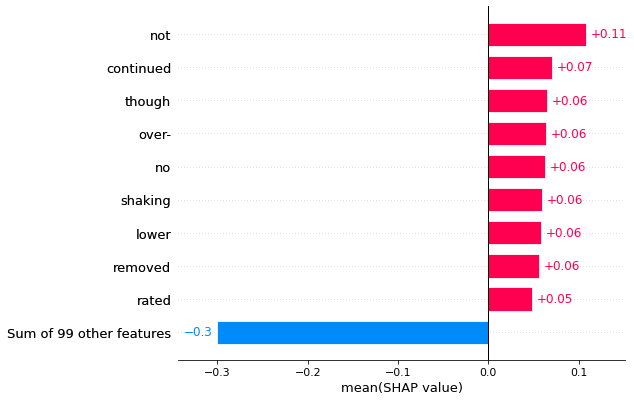

In [379]:
shap.plots.bar(shap_values[:,:,"negative"].mean(0), order=shap.Explanation.argsort.flip)

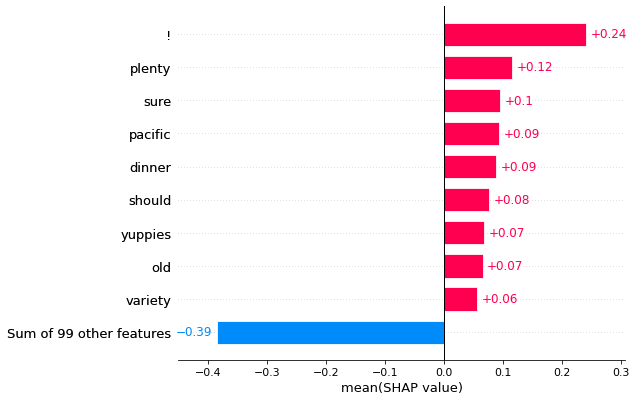

In [380]:
shap.plots.bar(shap_values[:,:,"positive"].mean(0), order=shap.Explanation.argsort.flip)

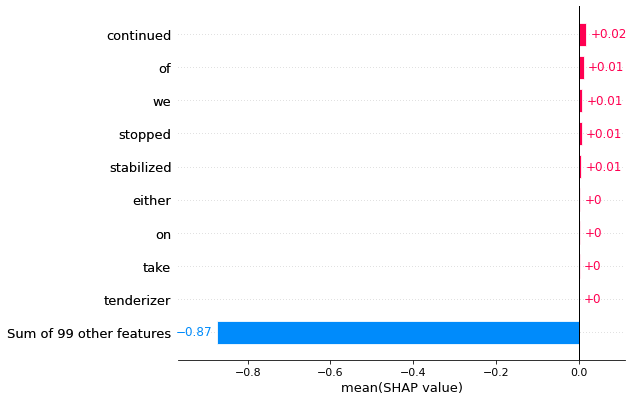

In [381]:
shap.plots.bar(shap_values[:,:,"neutral"].mean(0), order=shap.Explanation.argsort.flip)